<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

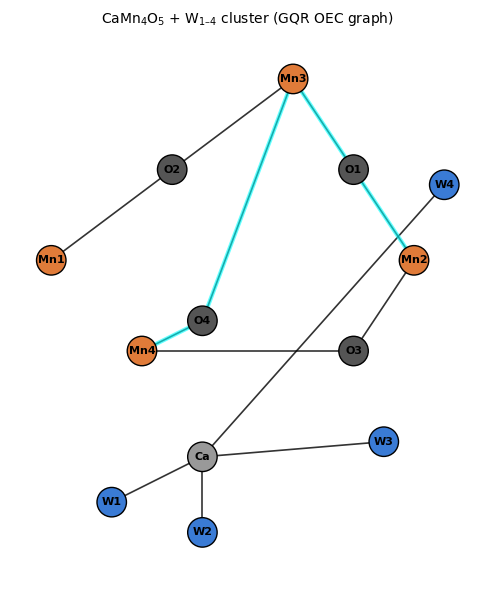

In [ ]:
# ==========================================================
# OEC_GQR_plot.py — schematic OEC graph for GQR–VIII
# ==========================================================
# Author: James R. F. Sutton (2025)
# Purpose: Draw the CaMn4O5 + W1–W4 cluster with realistic
# geometry and optional resonance flow overlay.
# ==========================================================

import matplotlib.pyplot as plt
import networkx as nx

# ---------- Graph definition ----------
G = nx.Graph()

# Node sets
metals = {
    "Mn1": (0.0, 1.6),
    "Mn2": (2.4, 1.6),
    "Mn3": (1.6, 2.8),
    "Mn4": (0.6, 1.0),
    "Ca":  (1.0, 0.3)
}

mu_oxo = {
    "O1": (2.0, 2.2),
    "O2": (0.8, 2.2),
    "O3": (2.0, 1.0),
    "O4": (1.0, 1.2)
}

waters = {
    "W1": (0.4, 0.0),
    "W2": (1.0, -0.2),
    "W3": (2.2, 0.4),
    "W4": (2.6, 2.1)
}

# Combine positions
pos = {**metals, **mu_oxo, **waters}

# Safe bond list (Mn–Oµ + Ca–W only)
edges = [
    ("Mn2", "O1"), ("O1", "Mn3"),
    ("Mn1", "O2"), ("O2", "Mn3"),
    ("Mn2", "O3"), ("O3", "Mn4"),
    ("Mn4", "O4"), ("O4", "Mn3"),
    ("Ca", "W1"), ("Ca", "W2"), ("Ca", "W3"), ("Ca", "W4")
]

G.add_edges_from(edges)

# ---------- Plot styling ----------
plt.figure(figsize=(6.5, 6))
ax = plt.gca()
ax.set_aspect('equal')
plt.axis('off')

# Node categories & colors
node_colors = []
for n in G.nodes:
    if n.startswith("Mn"):
        node_colors.append("#e07b39")   # orange Mn
    elif n == "Ca":
        node_colors.append("#999999")   # grey Ca
    elif n.startswith("O"):
        node_colors.append("#555555")   # dark gray µ-oxo
    else:
        node_colors.append("#3a7bd5")   # blue waters

# ---------- Draw the graph ----------
nx.draw_networkx_edges(G, pos, width=1.2, edge_color="black", alpha=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                       edgecolors='black', node_size=450)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# ---------- Optional overlay (e.g. tunnelling amplitude) ----------
# Example: highlight a hypothetical e– flow path
flow_path = [("Mn2","O1"), ("O1","Mn3"), ("Mn3","O4"), ("O4","Mn4")]
nx.draw_networkx_edges(G, pos, edgelist=flow_path,
                       width=3.0, edge_color="cyan", alpha=0.6)

plt.title("CaMn$_4$O$_5$ + W$_{1–4}$ cluster (GQR OEC graph)", fontsize=10)
plt.tight_layout()
plt.savefig("OEC_GQR_graph.png", dpi=600)
plt.show()

# ---------------- GPU/CPU toggle ----------------
USE_GPU = True
try:
    if USE_GPU:
        import cupy as xp                      # GPU arrays
        from cupy.linalg import eigh as xp_eigh
    else:
        raise ImportError
except Exception:
    import numpy as xp                         # CPU arrays
    from numpy.linalg import eigh as xp_eigh
    USE_GPU = False

# ---------------- Build Hamiltonian H(psi) ----------------
def propagate_tdse(H_func, psi0, dt, nsteps, record_idx=()):
    """Generic TDSE propagation with GPU/CPU backend.
       H_func(psi) -> H matrix (xp.ndarray, Hermitian).
    """
    psi = xp.asarray(psi0, dtype=xp.complex128)
    traces = []
    for n in range(nsteps):
        H = H_func(psi)                        # Hermitian (N x N)
        w, V = xp_eigh(H)                      # eigendecomp (GPU if CuPy)
        U = (V * xp.exp(-1j * w * dt)) @ V.conj().T
        psi = U @ psi
        psi = psi / xp.linalg.norm(psi)
        if n in record_idx:
            traces.append(xp.asnumpy(psi))     # bring back to CPU for plotting
    return traces

# Example H_func skeleton (insert your gated couplings here)
def H_func_example(psi):
    # build distance-gated t_ij with comb/shield/duty … return Hermitian H
    return H

In [ ]:
# ================================================================
# OEC_GQR_schematic.py — produce publication-quality Fig 1
# ================================================================
import numpy as np, matplotlib.pyplot as plt, json, os
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 300

OUT_DIR = "OEC_GQR_TDSE_MOVIE"
GEO_NPZ = os.path.join(OUT_DIR, "geometry_oec_3wu2_cached.npz")
assert os.path.exists(GEO_NPZ), "Run the main TDSE code once first."

g = np.load(GEO_NPZ, allow_pickle=True)
nodes  = g["nodes"]; labels = list(g["labels"]); groups = list(g["groups"])
pairs  = g["pairs"]
N = len(nodes)

def set_equal(ax, pts, pad=0.6):
    pts = np.asarray(pts)
    cx,cy,cz = pts.mean(axis=0)
    r = max(np.ptp(pts, axis=0))*0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

fig = plt.figure(figsize=(6.5,6))
ax  = fig.add_subplot(111, projection='3d')

# colours per group
cols = {'metal':'#777777', 'mu-oxo':'#E74C3C', 'water':'#4DA6FF'}
sizes= {'metal':260,'mu-oxo':200,'water':180}

# bonds (≤3.2 Å)
for (i,j,r) in pairs:
    if r<=3.2:
        xi,yi,zi = nodes[i]; xj,yj,zj = nodes[j]
        ax.plot([xi,xj],[yi,yj],[zi,zj],'k-',lw=1.0,alpha=0.35)

# nodes + labels
for i,(x,y,z) in enumerate(nodes):
    gcat=groups[i]
    ax.scatter([x],[y],[z],s=sizes[gcat],c=cols[gcat],ec='k',lw=0.4)
    ax.text(x,y,z+0.18,labels[i],fontsize=7,ha='center',va='bottom')

ax.view_init(elev=22, azim=25)
set_equal(ax,nodes)
ax.set_title("CaMn$_4$O$_5$ + W$_{1–4}$ cluster (geometry schematic)")
plt.tight_layout()
plt.savefig("Fig1_OEC_GQR_schema.png",dpi=600)
plt.show()
print("✅ Saved Fig1_OEC_GQR_schema.png")

AssertionError: Run the main TDSE code once first.